# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

In [1]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.11.0


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [2]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
# model, preprocess = clip.load("ViT-B/32")
model, preprocess = clip.load("ViT-L/14")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 427,616,513
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa95c7b19d0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
# Replace the original image pre-processor as we don't want to normalize the image using other dataset stats
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC


def _convert_image_to_rgb(image):
    return image.convert("RGB")

def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        # Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])


# preprocess = _transform(model.input_resolution.item())
preprocess = _transform(model.visual.input_resolution)

print(preprocess)


Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fa95b8f41f0>
    ToTensor()
)


In [9]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np
pylab.rcParams['figure.figsize'] = 20, 12

def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image


def imshow(img, caption, ShowFig = True, SaveFig = True, path = 'tmp.png'):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    plt.figtext(0.5, 0.09, caption, wrap=True, horizontalalignment='center', fontsize=20)

    if SaveFig:
        plt.savefig(path)

    if ShowFig:
        plt.show()


# def loadLocalImage(image_path):
#     pil_image = Image.open(image_path).convert("RGB")
#     # convert to BGR format
#     image = np.array(pil_image)[:, :, [2, 1, 0]]
#     return image


def loadLocalImage(image_path):
    pil_image = Image.open(image_path).convert("RGB")
#     # convert to BGR format
#     image = np.array(pil_image)[:, :, [2, 1, 0]]
    return pil_image

    
import os
import cv2

# import tqdm
# from tqdm.notebook import tqdm
import sys
from time import sleep
from tqdm import tqdm

import imageio

def saveAsGIF(image_list, video_name='temp.gif', fps=30):
    imageio.mimsave(video_name, image_list, fps = fps)


def saveAsVideo(image_list, video_name='temp.avi', fps=30):
    # out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps = 15, frameSize = len(image_list))
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps = fps, frameSize = image_list[0].shape[:2])
    # out = cv2.VideoWriter(filename = video_name, apiPreference = cv2.CAP_FFMPEG,  fourcc = cv2.VideoWriter_fourcc(*'DIVX'), fps = fps, frameSize = image_list[0].shape[:2])
    for img in image_list:
        out.write(img)
    out.release()


In [232]:
def plotResults(original_images, texts, similarity):
    
    # count = len(descriptions)
    # count = len(texts)
    count = len(original_images)

    plt.figure(figsize=(20, 14))
    plt.imshow(similarity, vmin=0.1, vmax=0.3)
    # plt.colorbar()
    # plt.yticks(range(count), texts, fontsize=18)
    plt.yticks(range(len(texts)), texts, fontsize=18)
    plt.xticks([])
    for i, image in enumerate(original_images):
        plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
    for x in range(similarity.shape[1]):
        for y in range(similarity.shape[0]):
            plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

    for side in ["left", "top", "right", "bottom"]:
      plt.gca().spines[side].set_visible(False)

    plt.xlim([-0.5, count - 0.5])
    plt.ylim([count + 0.5, -2])

    plt.title("Cosine similarity between text and image features", size=20)
    

def plotTopKImages(original_images, similarity, top_k = 5):

    # best_img_idx = similarity.argmax()
    # print(best_img_idx)
    # original_images[best_img_idx]
    
    similarity = similarity.squeeze(0)
    top_k_idx = np.argpartition(similarity, -top_k)[-top_k:]

    top_k_similarity = similarity[top_k_idx]
#     top_k_images = original_images[top_k_idx]

    sort_idx = top_k_similarity.argsort()
    top_k_idx = top_k_idx[sort_idx]
    
    top_k_similarity = top_k_similarity[sort_idx]
    print(f"top_k_similarity = {top_k_similarity}")
    
#     top_k_images = top_k_images[sort_idx]
    
    
    plt.figure(figsize=(16, 5))

    for idx, top_idx in enumerate(top_k_idx):
        plt.subplot(int(len(top_k_idx)/3)+1, 3, idx + 1)
        plt.imshow(original_images[top_idx])
        plt.title(f"Similarity score = {similarity[top_idx]}")
        plt.xticks([])
        plt.yticks([])

    plt.tight_layout()


In [235]:
def runCLIP(org_image, caption):

#     original_images = [org_image]
    original_images = generateCandidateCrops(org_image)
    
#     image = preprocess(org_image)
    image_inputs = [preprocess(i) for i in original_images]

#     image_inputs = [image for i in range(10)]
    image_inputs = torch.tensor(np.stack(image_inputs)).cuda()

    texts = [caption]
    text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
    
    
    # image_input = torch.tensor(np.stack(image)).cuda()
    # text_token = clip.tokenize(caption).cuda()


    with torch.no_grad():
        image_features = model.encode_image(image_inputs).float()
        text_features = model.encode_text(text_tokens).float()

    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

#     print(similarity)

    return original_images, texts, similarity

In [206]:
def addCrop(image, h, w, crop_orientation = 'height', no_crops = 5):
    
    if crop_orientation == 'height':
        crops = [image[i*int(h/no_crops):(i+1)*int(h/no_crops), :, :] for i in range(no_crops)]
        crops = [cv2.resize(i, (w,h)) for i in crops] #Resize image
        crops = [Image.fromarray(i) for i in crops] #Convert to PIL Image
    elif crop_orientation == 'width':
        crops = [image[:, i*int(w/no_crops):(i+1)*int(w/no_crops), :] for i in range(no_crops)]
        crops = [cv2.resize(i, (w,h)) for i in crops] #Resize image
        crops = [Image.fromarray(i) for i in crops] #Convert to PIL Image
    elif crop_orientation == 'both':
#         crops = [[image[i*int(h/no_crops):(i+1)*int(h/no_crops), j*int(w/no_crops):(j+1)*int(w/no_crops), :] for i in range(no_crops)] for j in range(no_crops)]
        
        crops = []
        [[crops.append(image[i*int(h/no_crops):(i+1)*int(h/no_crops), j*int(w/no_crops):(j+1)*int(w/no_crops), :]) for i in range(no_crops)] for j in range(no_crops)]        
    
        crops = [cv2.resize(i, (w,h)) for i in crops] #Resize image
        crops = [Image.fromarray(i) for i in crops] #Convert to PIL Image
    else:
        raise Exception(f"Error! Undefined crop_orientation = {crop_orientation}")
        
    return crops

def generateCandidateCrops(org_image):

    all_images = [org_image]

    image = np.array(org_image)[:, :, [2, 1, 0]]
    print(image.shape)

    h,w,c = image.shape

    all_images += addCrop(image, h, w, crop_orientation = 'height', no_crops = 3)
    all_images += addCrop(image, h, w, crop_orientation = 'width', no_crops = 3)
    all_images += addCrop(image, h, w, crop_orientation = 'both', no_crops = 3)
    
    all_images += addCrop(image, h, w, crop_orientation = 'height', no_crops = 5)
    all_images += addCrop(image, h, w, crop_orientation = 'width', no_crops = 5)
    all_images += addCrop(image, h, w, crop_orientation = 'both', no_crops = 5)
    
    
    all_images += addCrop(image, h, w, crop_orientation = 'height', no_crops = 10)
    all_images += addCrop(image, h, w, crop_orientation = 'width', no_crops = 10)
    all_images += addCrop(image, h, w, crop_orientation = 'both', no_crops = 10)

    return all_images

In [207]:
crops = generateCandidateCrops(org_image)

(601, 382, 3)


(601, 382, 3)
top_k_similarity = [0.21665369 0.21807724 0.21825032 0.21853027 0.21864706 0.21913981
 0.22015393 0.22102344 0.22123489 0.2245376  0.22456187 0.22458178
 0.23166555 0.23284665 0.2380402 ]


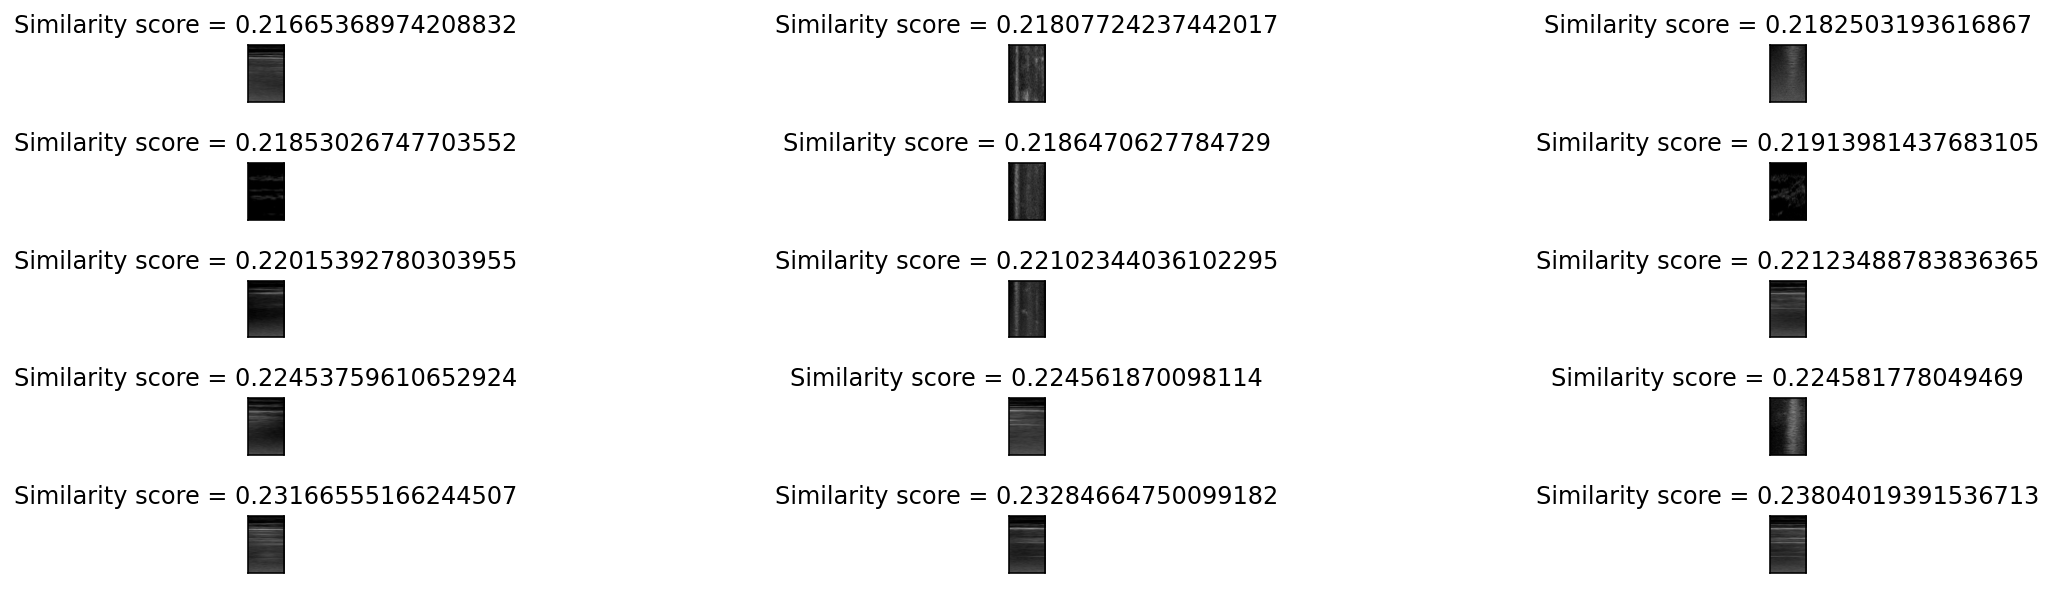

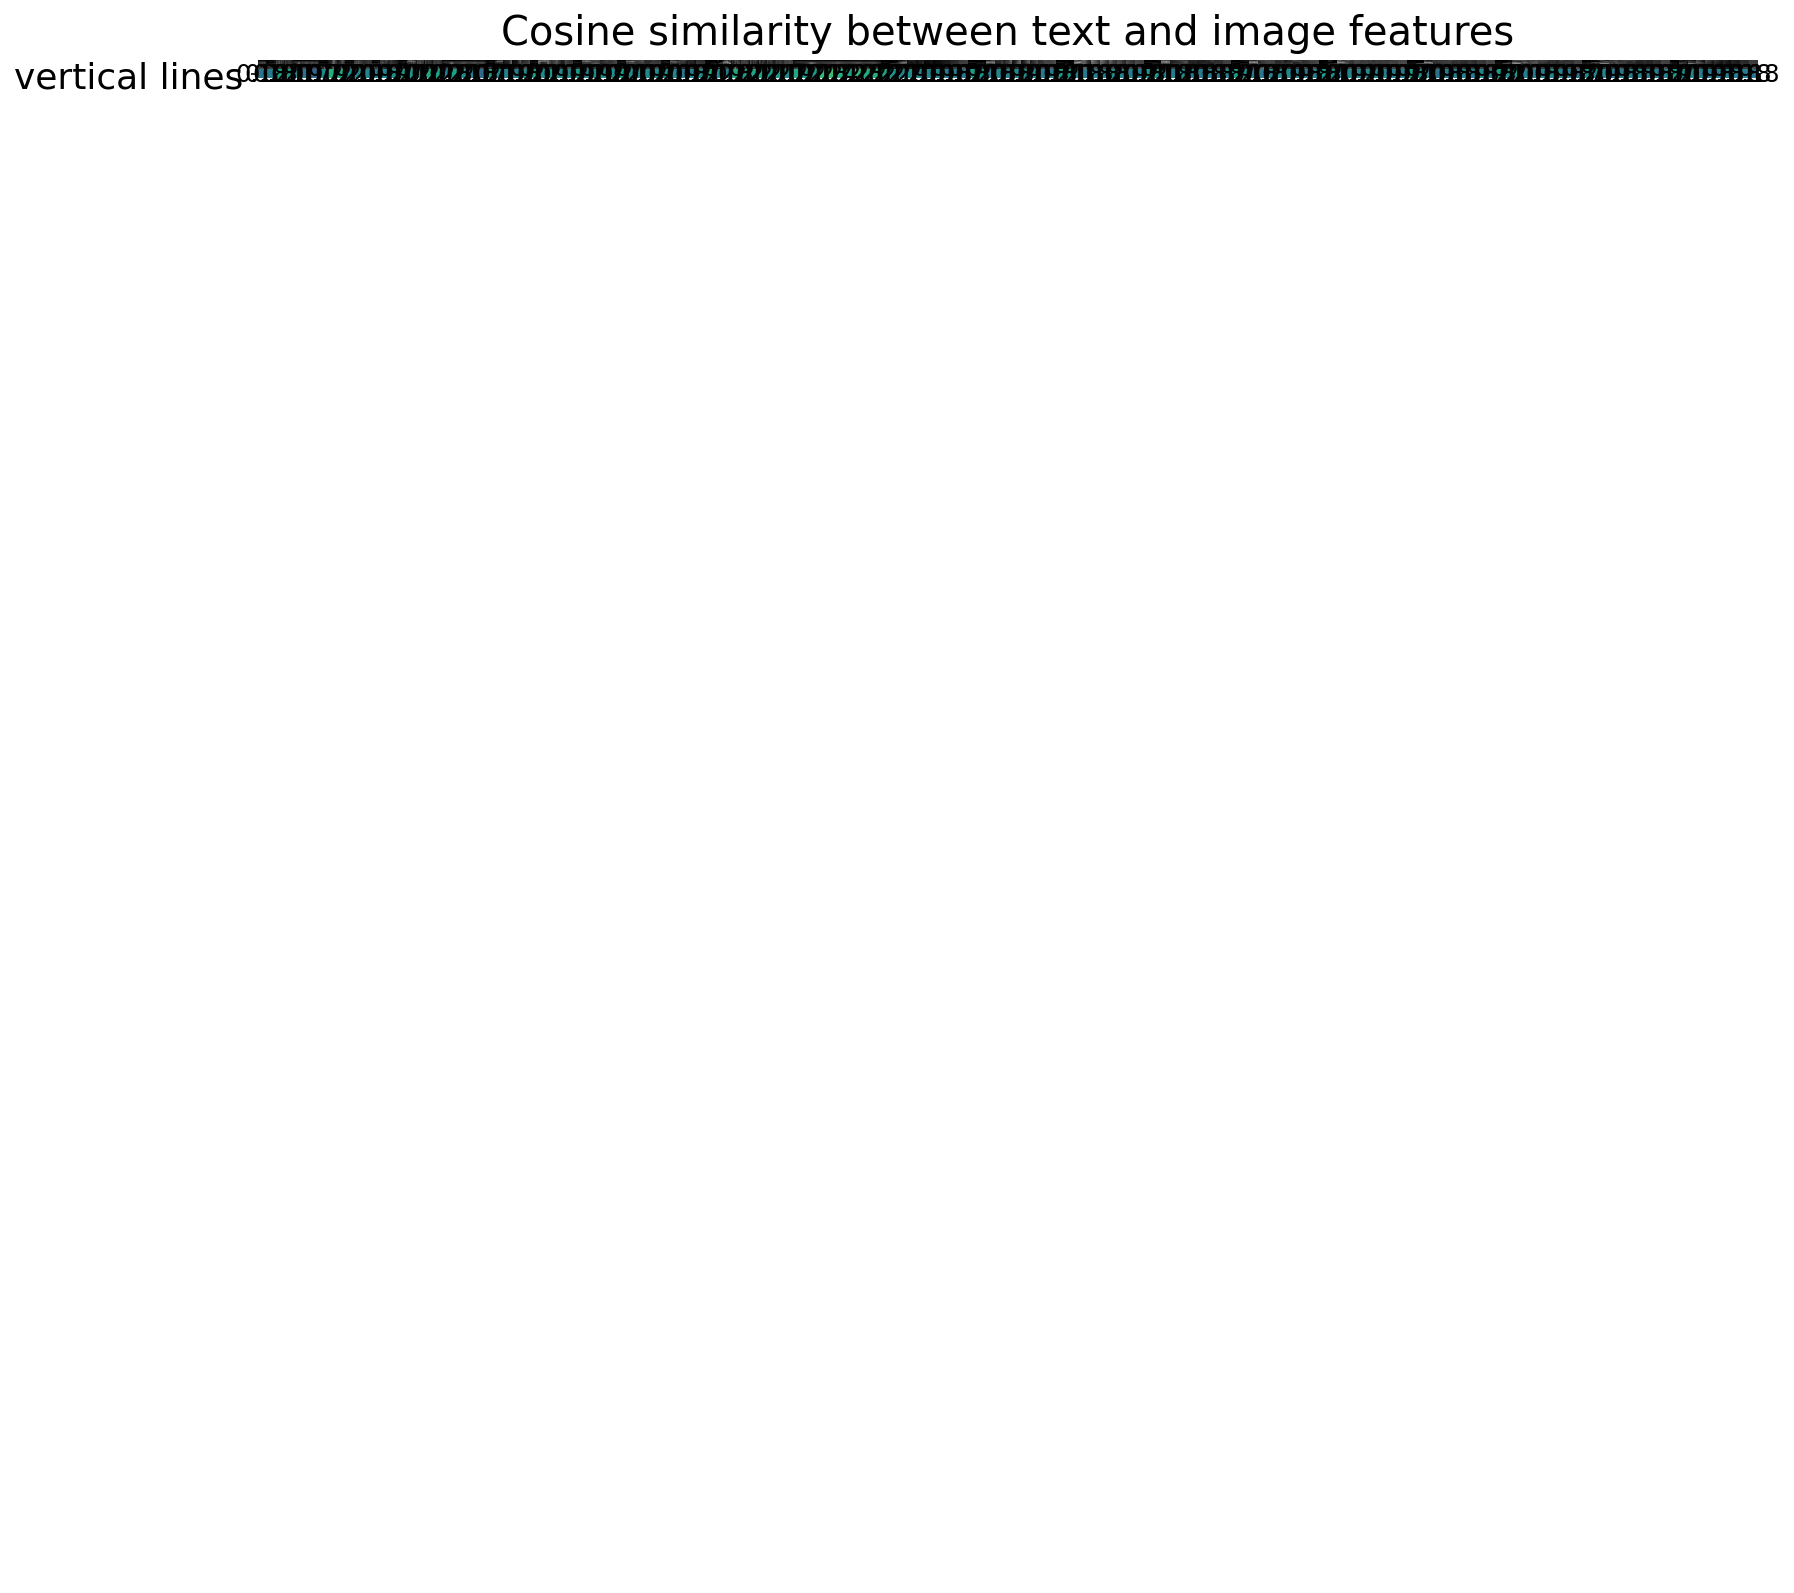

In [236]:
dataset_path = "/data1/datasets/LSU-LargeV2-Dataset"

# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/0d/0d-1/crop/00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/106/106-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/149/149-2/crop/00156.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/15/15-1/crop/00136.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/15/15-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/189/189-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/161/161-6/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/189/189-1/crop/00160.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/106/106-1/crop/00156.png"
image_path = "106/106-1/crop/00006.png"

image_path = os.path.join(dataset_path, image_path)

# caption = 'lines . horizontal lines . vertical lines' # the caption can also be the simple concatonation of some random categories.
# caption = 'vertical lines' # the caption can also be the simple concatonation of some random categories.
# caption = 'horizontal lines' # the caption can also be the simple concatonation of some random categories.
caption = 'vertical lines' # the caption can also be the simple concatonation of some random categories.

org_image = loadLocalImage(image_path)

original_images, texts, similarity = runCLIP(org_image, caption)

plotTopKImages(original_images, similarity, top_k = 15)

plotResults(original_images, texts, similarity)

(601, 382, 3)
top_k_similarity = [0.21665369 0.21807724 0.21825032 0.21853027 0.21864706 0.21913981
 0.22015393 0.22102344 0.22123489 0.2245376  0.22456187 0.22458178
 0.23166555 0.23284665 0.2380402 ]


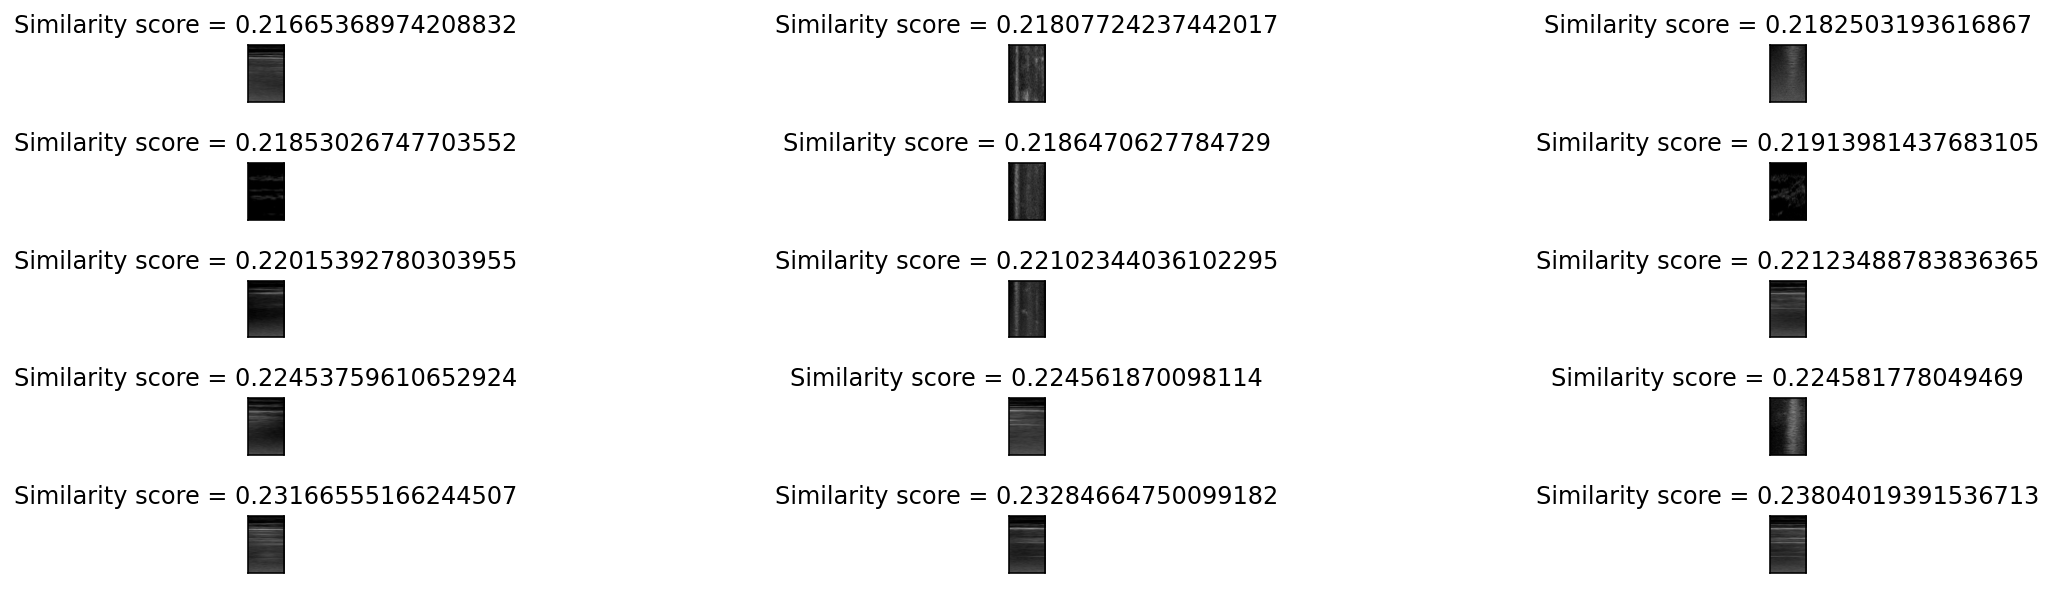

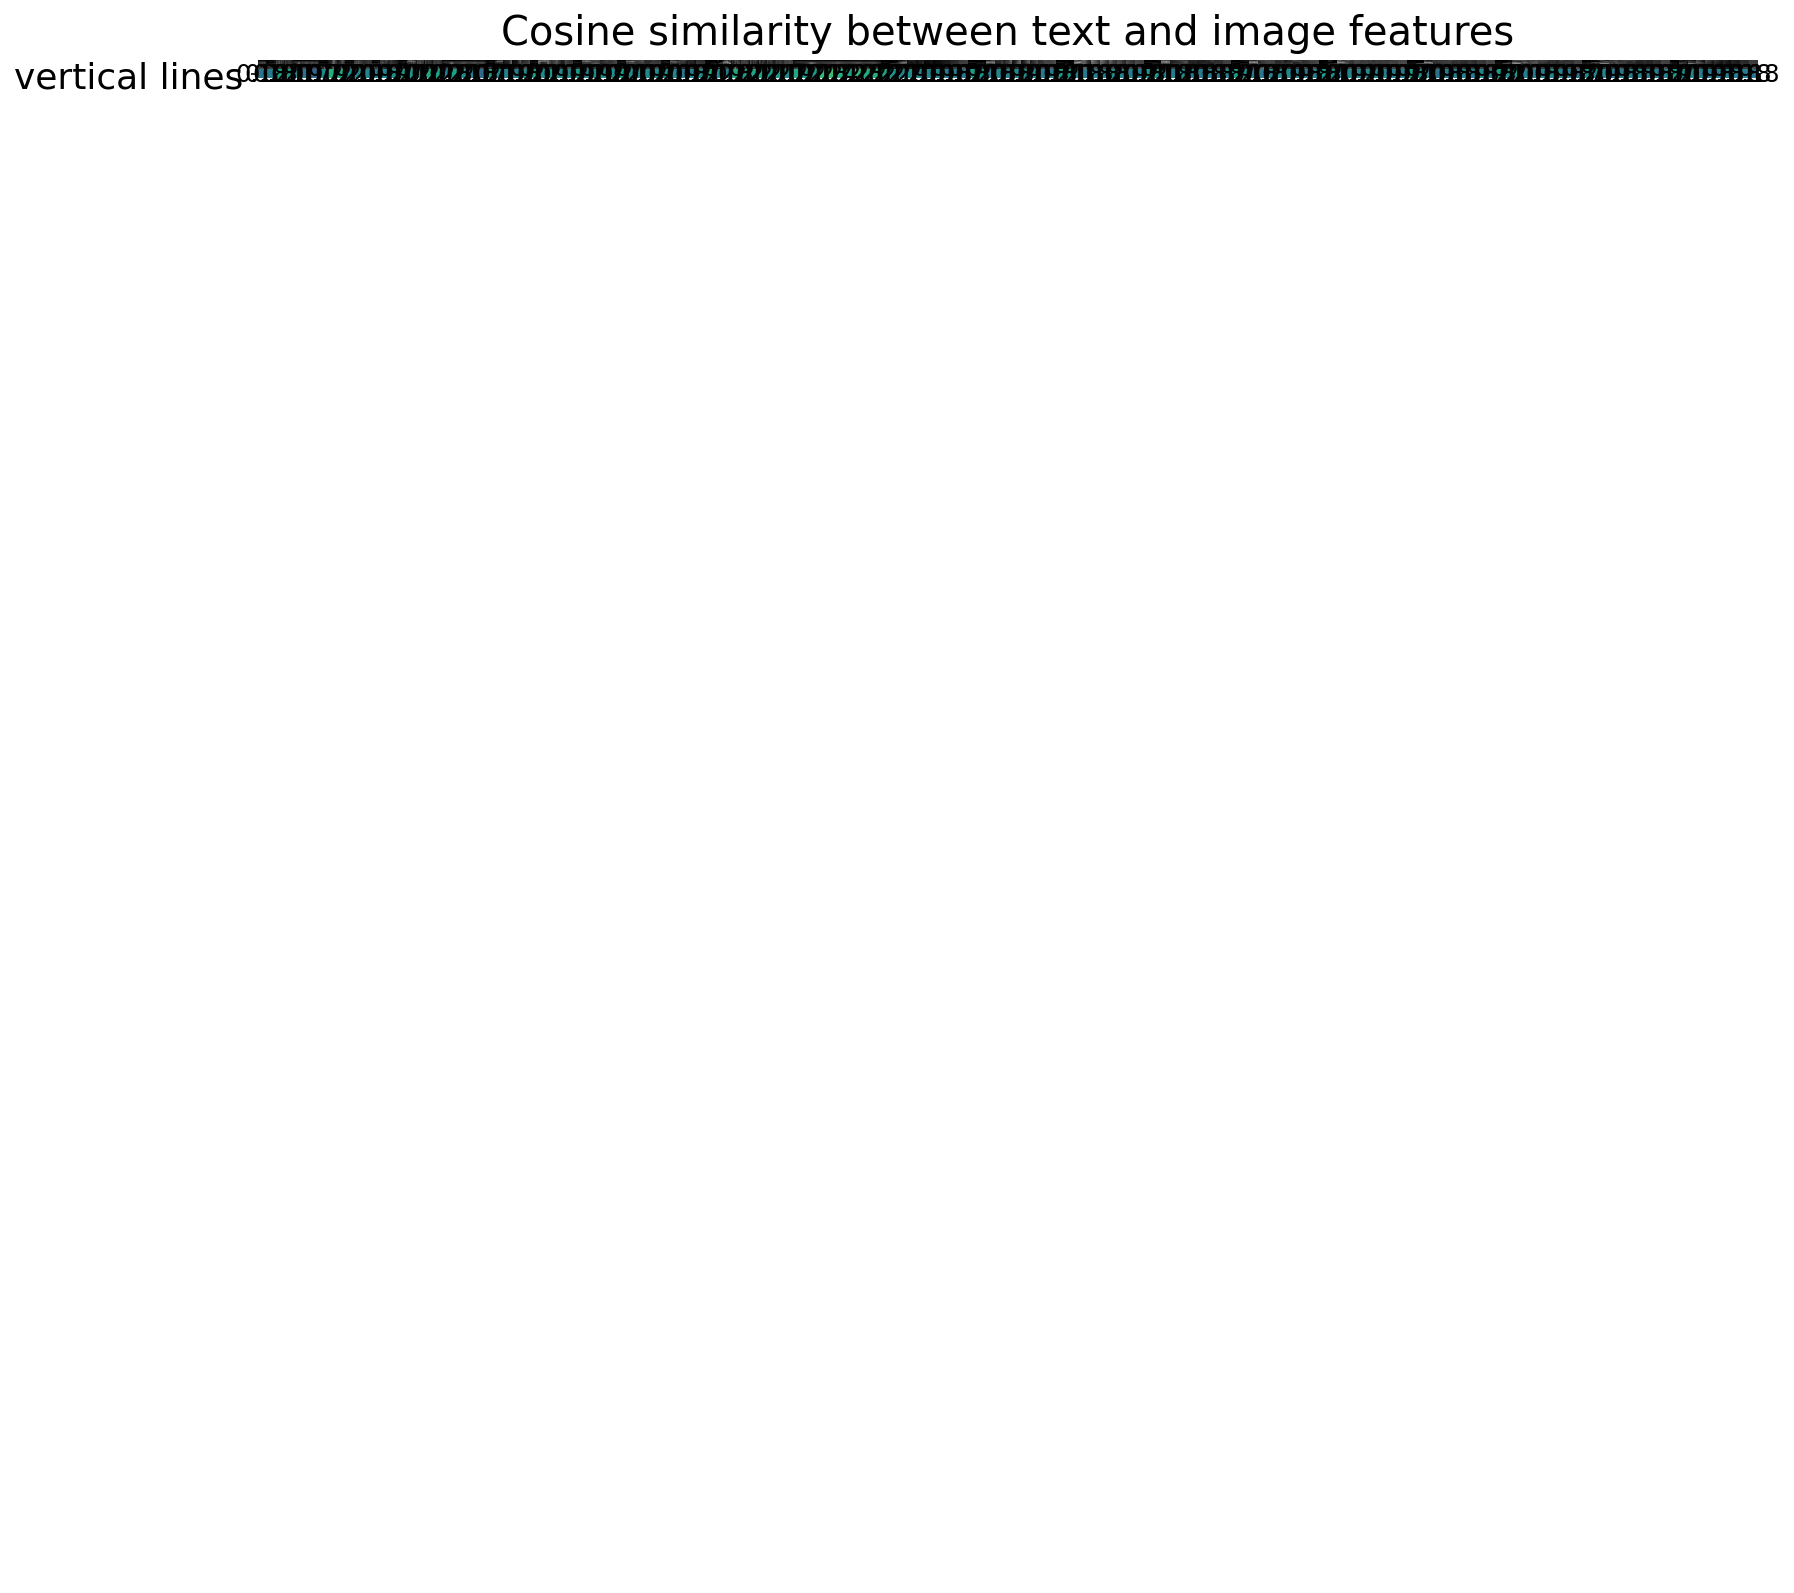

In [236]:
dataset_path = "/data1/datasets/LSU-LargeV2-Dataset"

# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/0d/0d-1/crop/00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/106/106-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/149/149-2/crop/00156.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/15/15-1/crop/00136.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/15/15-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/189/189-1/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/161/161-6/crop//00001.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/189/189-1/crop/00160.png"
# image_path = "/workspace/Research/GLIP/DATASET/LSU-LargeV2-Dataset/106/106-1/crop/00156.png"
image_path = "106/106-1/crop/00006.png"

image_path = os.path.join(dataset_path, image_path)

# caption = 'lines . horizontal lines . vertical lines' # the caption can also be the simple concatonation of some random categories.
# caption = 'vertical lines' # the caption can also be the simple concatonation of some random categories.
# caption = 'horizontal lines' # the caption can also be the simple concatonation of some random categories.
caption = 'vertical lines' # the caption can also be the simple concatonation of some random categories.

org_image = loadLocalImage(image_path)

original_images, texts, similarity = runCLIP(org_image, caption)

plotTopKImages(original_images, similarity, top_k = 15)

plotResults(original_images, texts, similarity)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

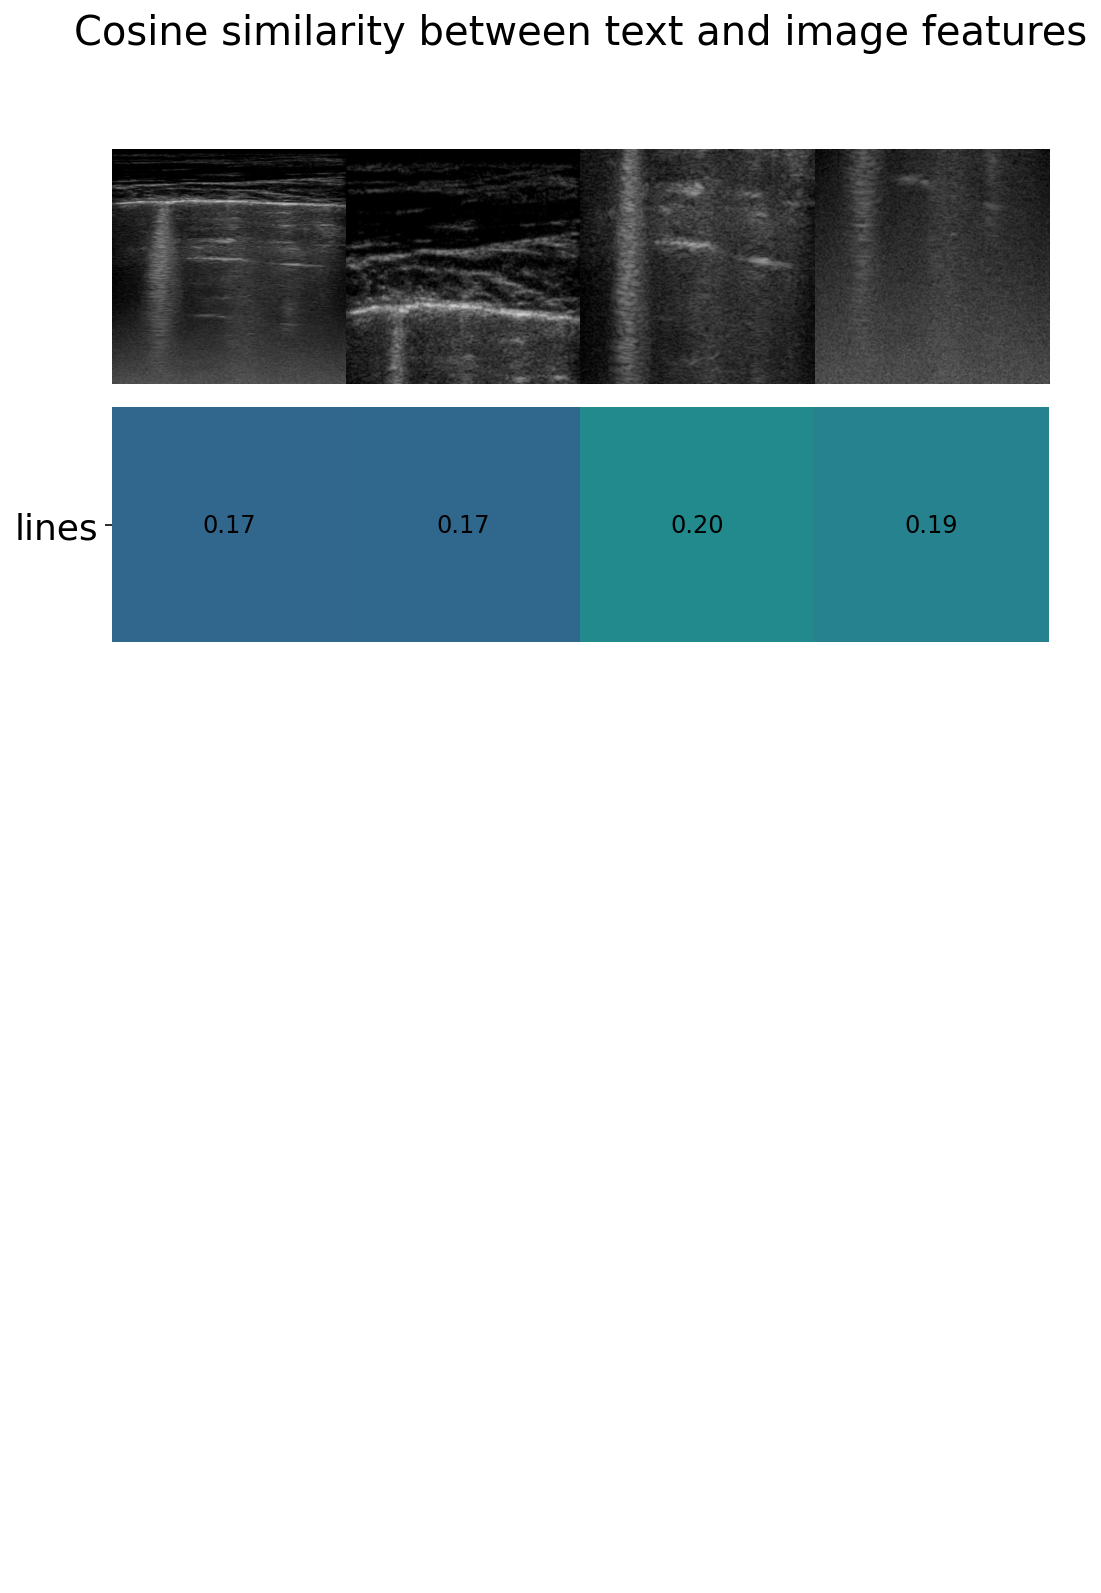

In [127]:
# count = len(descriptions)
# count = len(texts)
count = len(original_images)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(len(texts)), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [12]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [114]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

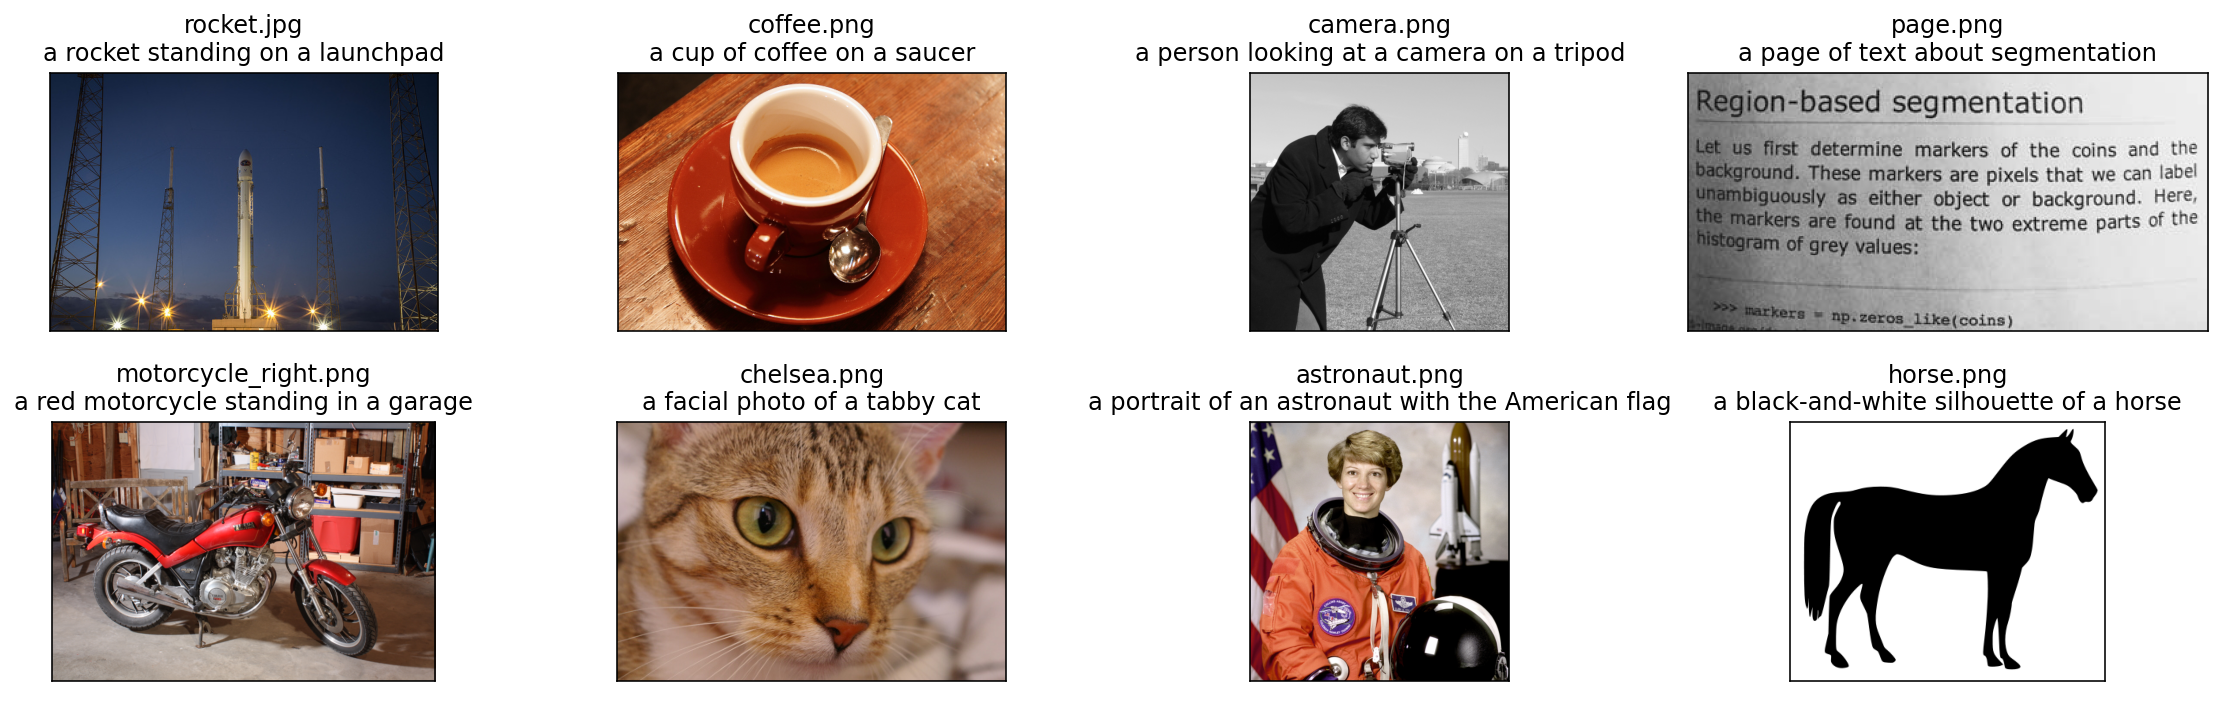

In [115]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [116]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [117]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [118]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

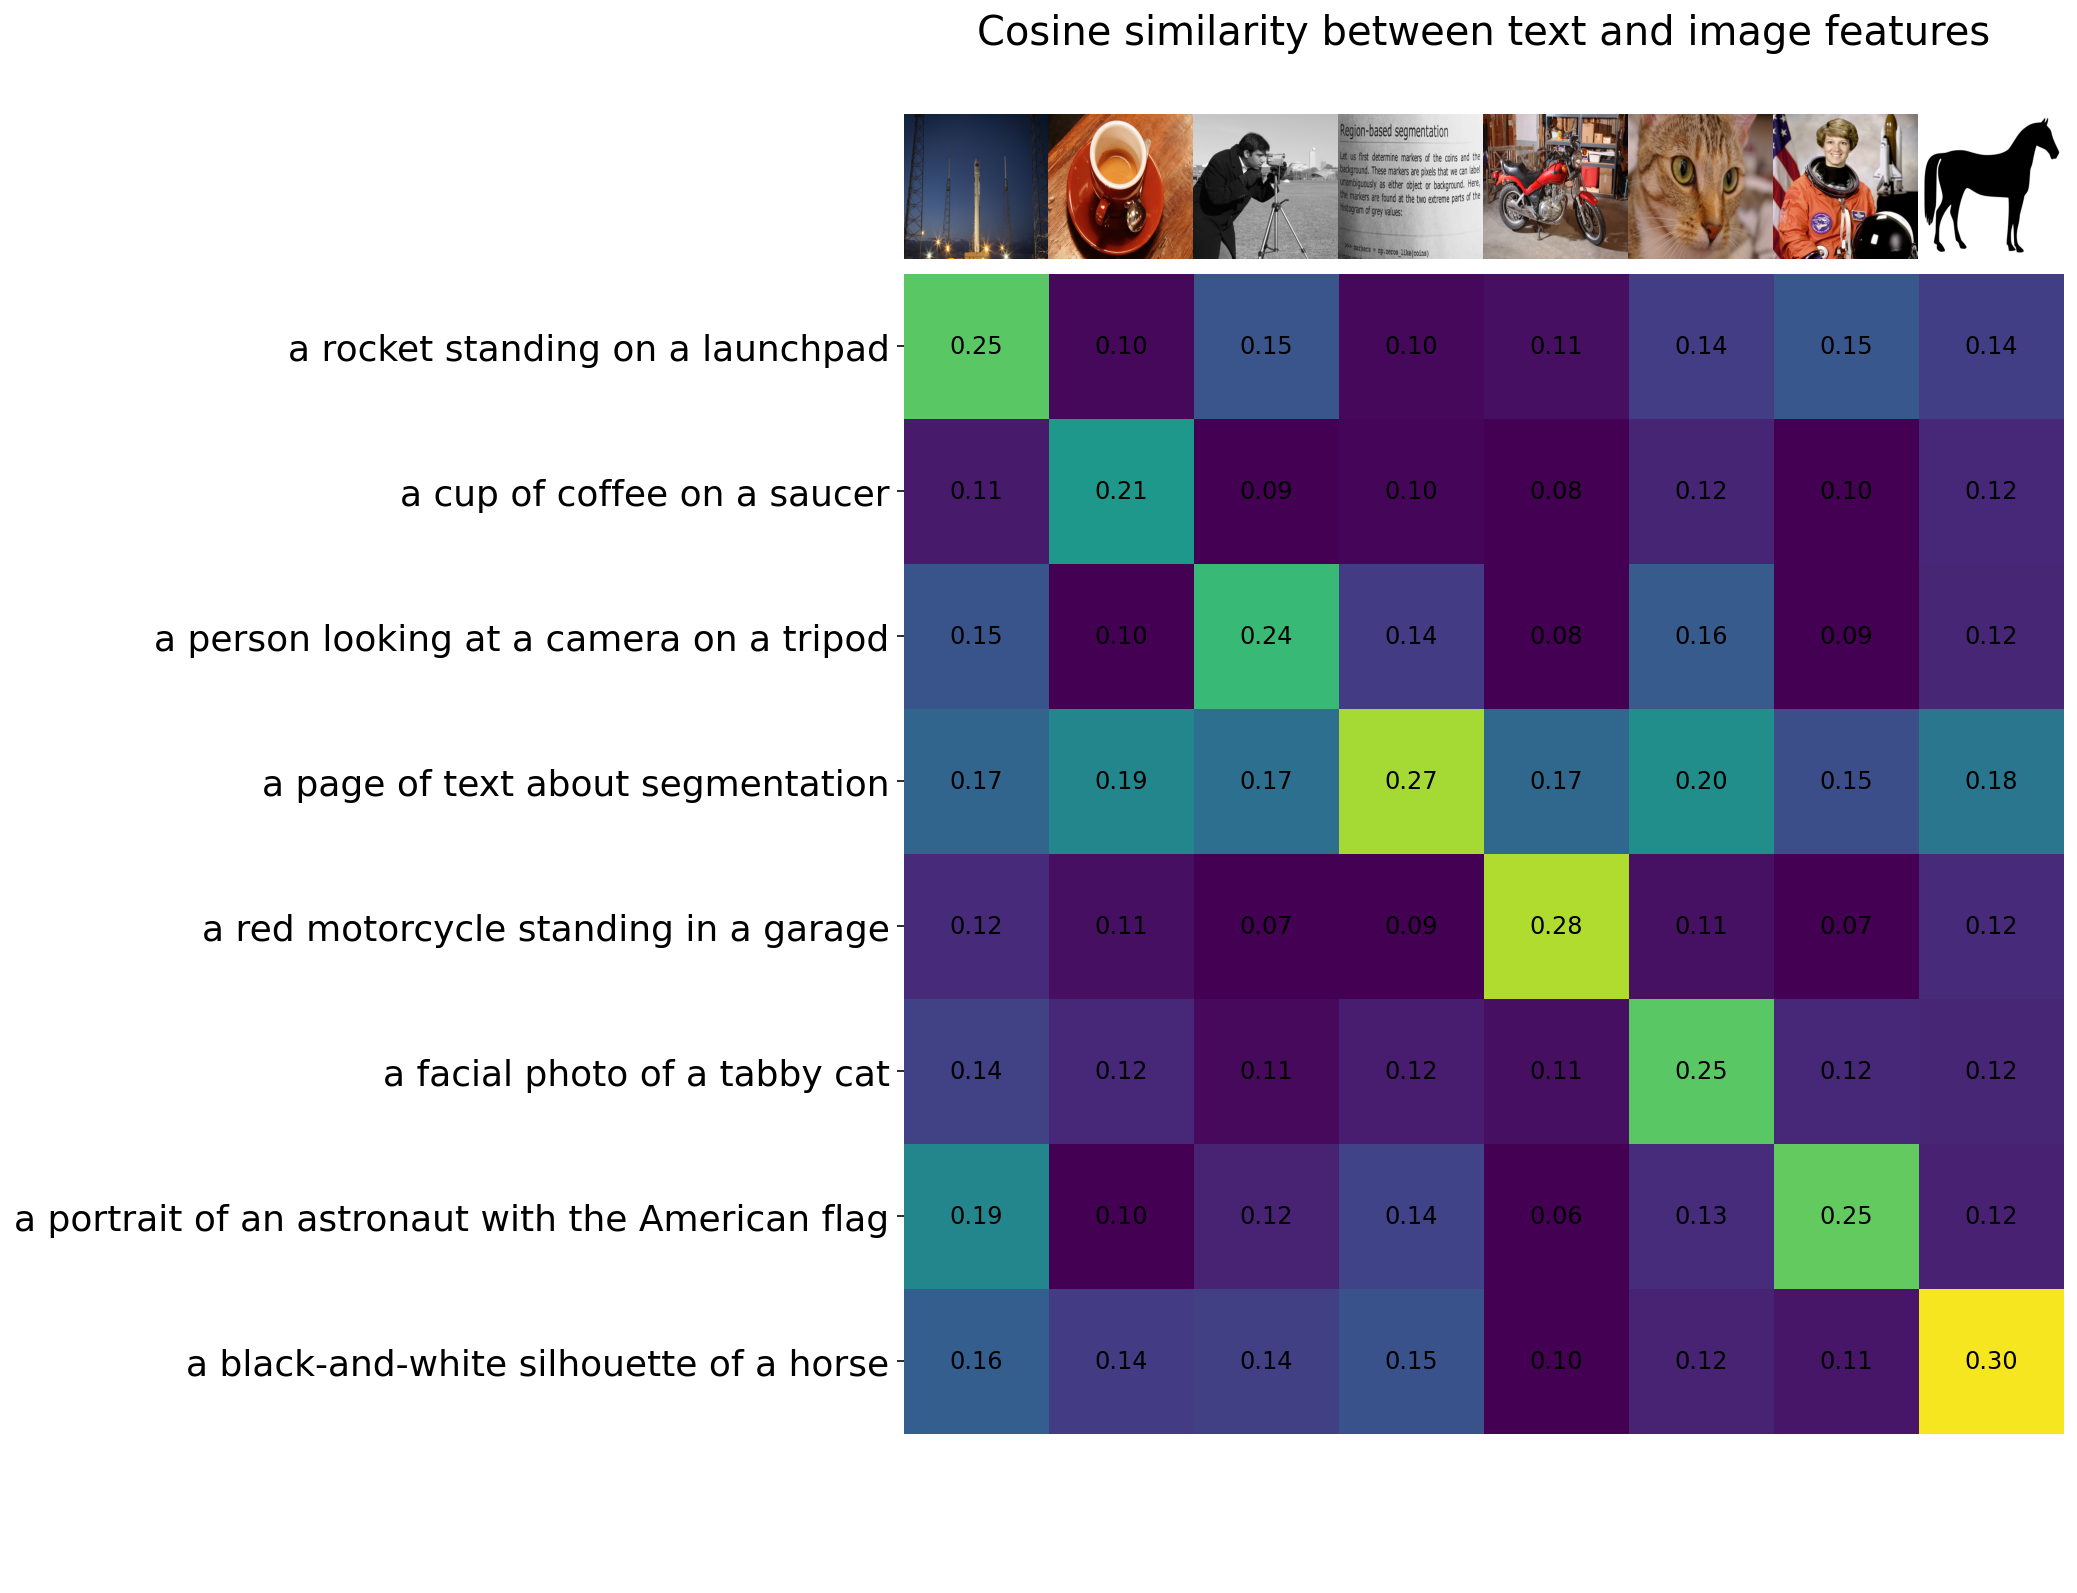

In [119]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [13]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [14]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [15]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

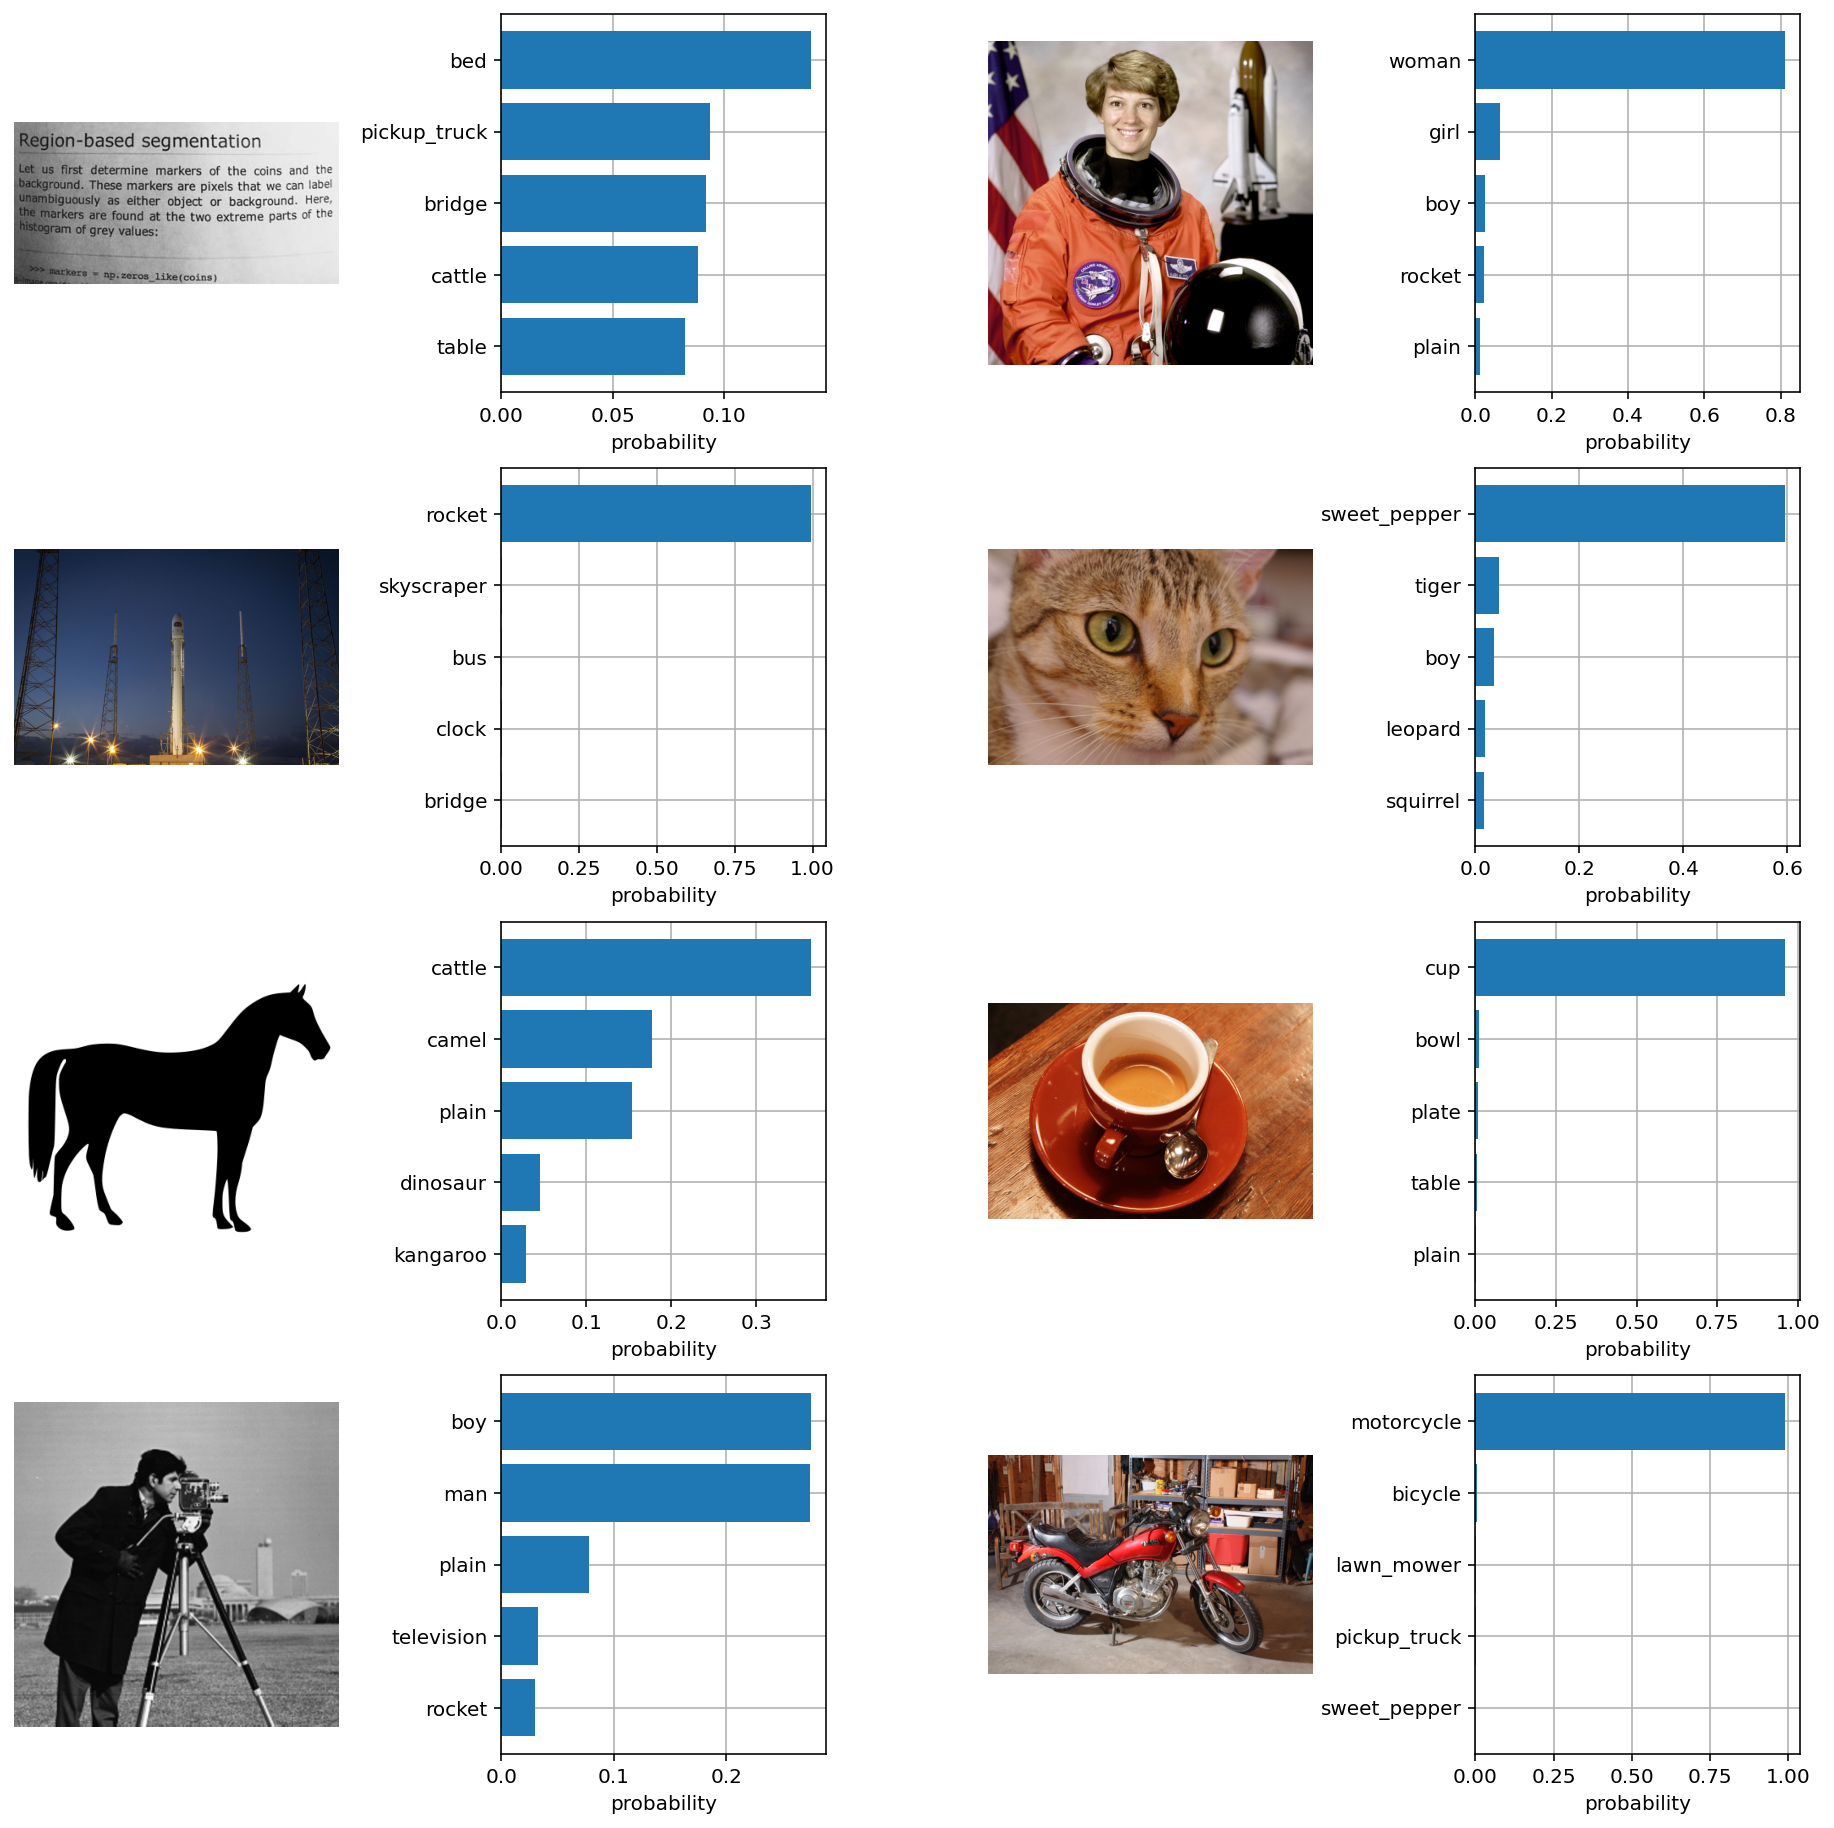

In [16]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()